In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
from pathlib import Path
import datetime as dt
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import json


In [3]:
def load_ior_summary_list(json_file: Path):
    data = json.loads(json_file.read_text())
    return [
        {
            'Version': data['Version'],
            'Began': data['Began'],
            'Command line': data['Command line'],
            'Machine': data['Machine'],
            'Finished': data['Finished'],
            **{f'test_{k}': v for k, v in test.items() if k not in ["Results", "max", "Parameters", "Options"]},
            **{f"max_{k}": v for k, v in test["max"].items()},
            **{f"Parameters_{k}": v for k, v in test["Parameters"].items()},
            **{f"Options_{k}": v for k, v in test["Options"].items()},
            **{f'summary_{k}': v for k, v in data['summary'][index].items()},
            **{f'result_{k}': v for k, v in result.items()},
            'iorIteration': iteration,
        }
        for index, test in enumerate(data['tests'])
        for iteration, results in enumerate(test["Results"]) # iteration ?
        for result in results
    ]

In [4]:
IOR_OUTPUT_DIR = Path("../raw/ior")

df_src = pl.DataFrame([
    log
    for log_dir in IOR_OUTPUT_DIR.glob("*")
    for json in log_dir.glob("ior_summary_*.json")
    for log in load_ior_summary_list(json)
])

df_src.head(5)

Version,Began,Command line,Machine,Finished,test_TestID,test_StartTime,test_Path,test_Capacity,test_Used Capacity,test_Inodes,test_Used Inodes,max_writeMiB,max_writeMB,Parameters_testID,Parameters_refnum,Parameters_api,Parameters_platform,Parameters_testFileName,Parameters_hintsFileName,Parameters_deadlineForStonewall,Parameters_stoneWallingWearOut,Parameters_maxTimeDuration,Parameters_outlierThreshold,Parameters_options,Parameters_dryRun,Parameters_nodes,Parameters_memoryPerTask,Parameters_memoryPerNode,Parameters_tasksPerNode,Parameters_repetitions,Parameters_multiFile,Parameters_interTestDelay,Parameters_fsync,Parameters_fsyncperwrite,Parameters_useExistingTestFile,Parameters_showHints,…,summary_TestID,summary_ReferenceNumber,summary_segmentCount,summary_blockSize,summary_transferSize,summary_numTasks,summary_tasksPerNode,summary_repetitions,summary_filePerProc,summary_reorderTasks,summary_taskPerNodeOffset,summary_reorderTasksRandom,summary_reorderTasksRandomSeed,summary_bwMaxMIB,summary_bwMinMIB,summary_bwMeanMIB,summary_bwStdMIB,summary_OPsMax,summary_OPsMin,summary_OPsMean,summary_OPsSD,summary_MeanTime,summary_xsizeMiB,result_access,result_bwMiB,result_blockKiB,result_xferKiB,result_iops,result_latency,result_openTime,result_wrRdTime,result_closeTime,result_totalTime,iorIteration,max_readMiB,max_readMB,Options_task offset
str,str,str,str,str,i64,str,str,str,str,str,str,f64,f64,i64,i64,str,str,str,str,i64,i64,i64,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,f64,f64,i64
"""3.3.0""","""Mon May 13 07:04:53 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux h1""","""Mon May 13 07:04:53 2024""",0,"""Mon May 13 07:04:53 2024""","""/workspaces/peanuts-playground…","""250.9 GiB""","""22.1%""","""16.0 Mi""","""7.6%""",162.0013,169.8707,0,0,"""MPIIO""","""h1(Linux)""","""/workspaces/peanuts-playground…","""(null)""",0,0,0,0,"""(null)""",0,4,0,0,1,1,0,0,1,0,0,0,…,0,0,1,4230720,47008,4,1,1,0,0,1,0,0,162.0013,162.0013,162.0013,0.0,3613.6557,3613.6557,3613.6557,0.0,0.0996,16.1389,"""write""",162.0013,4131.5625,45.9062,3628.8195,0.0011,0.0003,0.0992,0.0,0.0996,0,null,null,null
"""3.3.0""","""Mon May 13 07:04:51 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux h1""","""Mon May 13 07:04:51 2024""",0,"""Mon May 13 07:04:51 2024""","""/workspaces/peanuts-playground…","""250.9 GiB""","""22.1%""","""16.0 Mi""","""7.6%""",null,null,0,0,"""MPIIO""","""h1(Linux)""","""/workspaces/peanuts-playground…","""(null)""",0,0,0,0,"""(null)""",0,4,0,0,1,1,0,0,1,0,0,0,…,0,0,1,4194304,2097152,4,1,1,0,0,1,0,0,2533.1578,2533.1578,2533.1578,0.0,1266.5789,1266.5789,1266.5789,0.0,0.0063,16.0,"""read""",2533.1578,4096.0,2048.0,1509.5755,0.002,0.0009,0.0053,0.0,0.0063,0,2533.1578,2656.2085,null
"""3.3.0""","""Mon May 13 07:04:46 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux h1""","""Mon May 13 07:04:46 2024""",0,"""Mon May 13 07:04:46 2024""","""/workspaces/peanuts-playground…","""250.9 GiB""","""22.1%""","""16.0 Mi""","""7.6%""",113.4469,118.9576,0,0,"""MPIIO""","""h1(Linux)""","""/workspaces/peanuts-playground…","""(null)""",0,0,0,0,"""(null)""",0,2,0,0,1,1,0,0,1,0,0,0,…,0,0,1,4194304,32768,2,1,1,0,0,1,0,0,113.4469,113.4469,113.4469,0.0,3630.2993,3630.2993,3630.2993,0.0,0.0705,8.0,"""write""",113.4469,4096.0,32.0,3644.2886,0.0005,0.0002,0.0702,0.0,0.0705,0,null,null,null
"""3.3.0""","""Mon May 13 07:04:54 2024""","""ior -a MPIIO -l timestamp -g -…","""Linux h1""","""Mon May 13 07:04:54 2024""",0,"""Mon May 13 07:04:54 2024""","""/workspaces/peanuts-playground…","""250.9 GiB""","""22.1%""","""16.0 Mi""","""7.6%""",null,null,0,0,"""MPIIO""","""h1(Linux)""","""/workspaces/peanuts-playground…","""(null)""",0,0,0,0,"""(null)""",0,4,0,0,1,1,0,0,1,0,0,0,…,0,0,1,4230720,47008,4,1,1,0,1,1,0,0,1607.6035,1607.6035,1607.6035,0.0,35859.7346,35859.7346,35859.7346,0.0,0.01,16.1389,"""read""",1607.6035,4131.5625,45.9

Access: write, Remote: False


Options_nodes,8192,16384,32768,47008,1048576,2097152
i64,f64,f64,f64,f64,f64,f64
2,24.6174,49.625,113.4469,148.895,705.3736,947.4431
4,27.6023,56.5632,109.596,162.0013,1248.7214,1286.2301


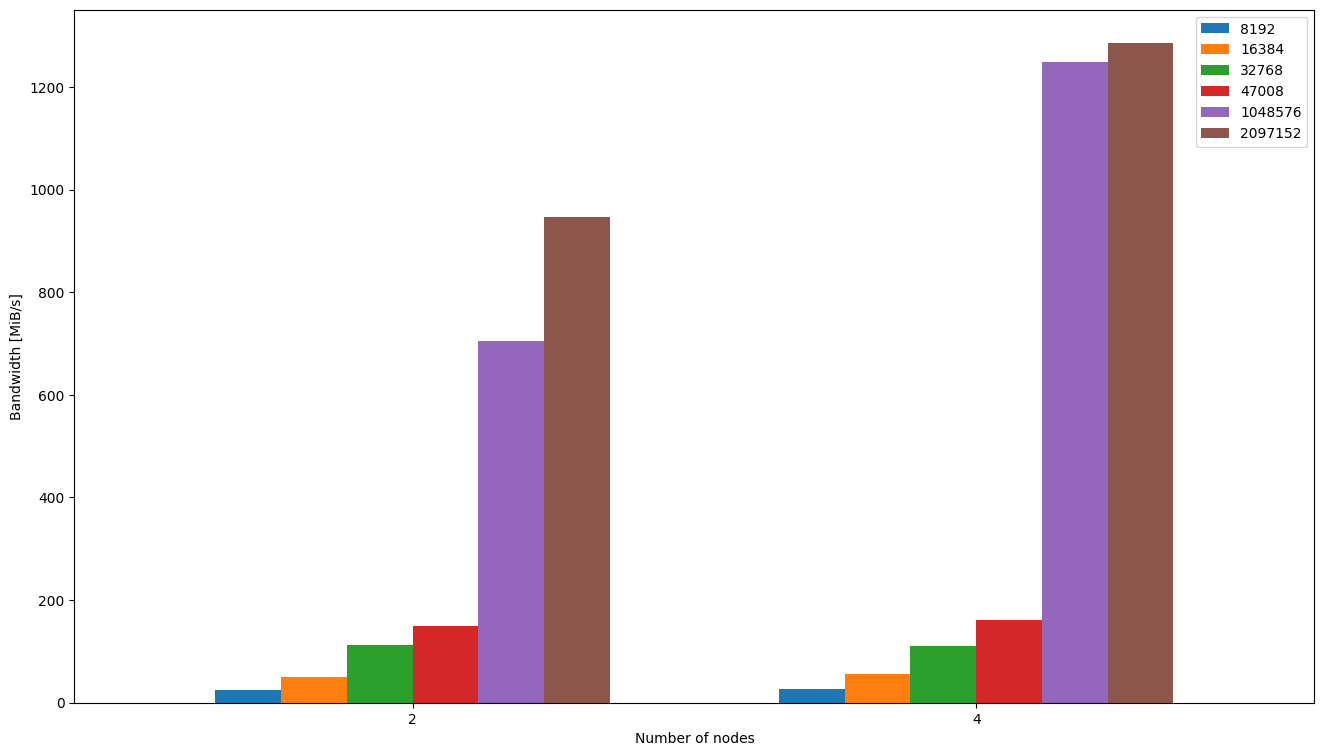

Access: read, Remote: True


Options_nodes,8192,16384,32768,47008,1048576,2097152
i64,f64,f64,f64,f64,f64,f64
2,530.9793,750.6856,809.4461,850.1281,779.0364,527.3588
4,1009.0483,1467.1308,1177.3792,1607.6035,1461.2984,1380.0797


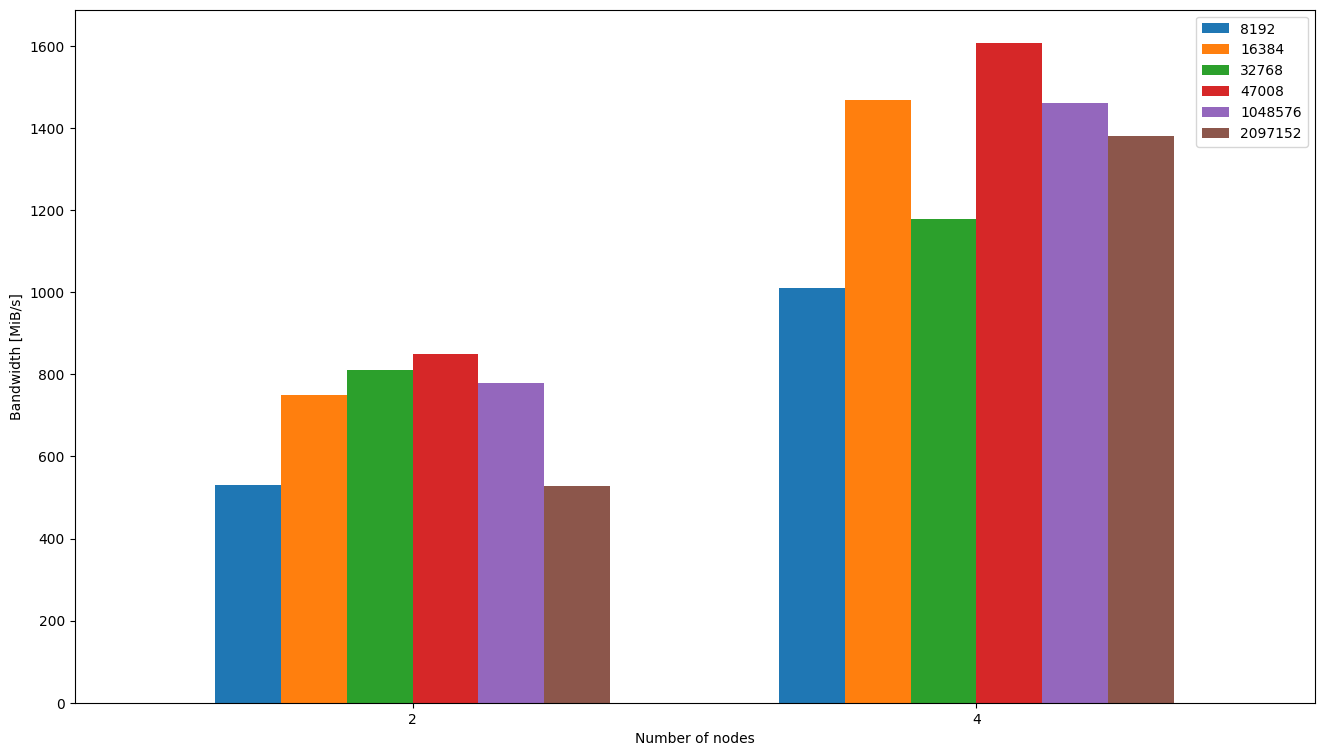

Access: read, Remote: False


Options_nodes,8192,16384,32768,47008,1048576,2097152
i64,f64,f64,f64,f64,f64,f64
2,1498.3712,1476.631,1432.0016,700.2291,916.3318,1431.0372
4,1563.6478,2616.2271,2392.6897,1781.5758,2471.1505,2533.1578


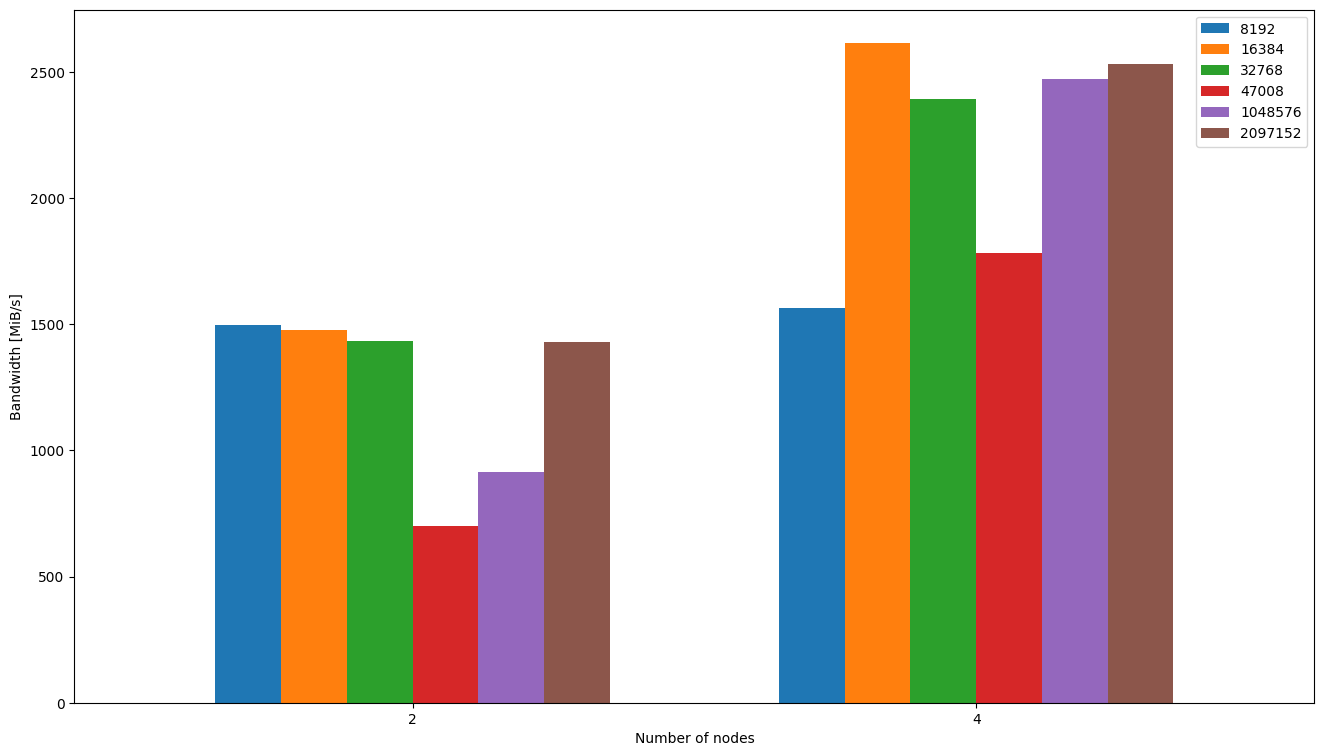

In [6]:
df = df_src

groupby_columns=[
    "Options_nodes",
    "summary_numTasks",
    "summary_reorderTasks",
    "summary_transferSize",
    "result_access",
]

df_plot = (
    df
    .with_columns(
        pl.col("summary_reorderTasks").cast(pl.Boolean),
    )
    .group_by(groupby_columns)
    .agg([
        pl.mean("result_bwMiB").alias("result_bwMiB_mean"),
    ])
)

for access, remote in [("write", False), ("read", True), ("read", False)]:
    print(f"Access: {access}, Remote: {remote}")
    fig = plt.figure(figsize=(16, 9), dpi=100)
    fig.patch.set_alpha(1)
    (
        df_plot
        .filter((pl.col("result_access") == access) & (pl.col("summary_reorderTasks") == remote))
        .sort(["Options_nodes", "summary_transferSize"])
        .pivot(values="result_bwMiB_mean", index="Options_nodes", columns="summary_transferSize")
        .pipe(lambda df: (display(df), df)[-1])
        .to_pandas()
        .set_index("Options_nodes")
        .plot(
            ax=fig.add_subplot(),
            kind="bar",
            xlabel="Number of nodes",
            ylabel="Bandwidth [MiB/s]",
            rot=0,
            width=0.7,
        )
    )
    plt.show()
